In [1]:
import os

# Config parameters
root = "/home/ali/graham-akhanf/EpLink/Eplink"
local_root = "/home/ali/Workspace/EpLink/Eplink"

atlases = ["none", "Desikan", "Glasser2016", "Schaefer2018_Kong2022_400", "Yan2023_Kong2022_400"]
atlases_aliases = ["Vertex", "Desikan", "Glasser 2016", "Schaefer 2018", "Yan 2023"]
atlases_path = os.path.join(local_root,"ISC-pipeline","resources","atlases_fsLR_32K",'cleaned_versions')

dataset = "eplink-p3"
task = "movie"
resampled = "N"
fwhm = 0
confounds_idx = 1

results_path = os.path.join(root,"ISC-pipeline","results",f"{dataset}", "pwISC")
file_pattern = os.path.join(results_path,f"pwISC_task-{task}_hemi-{{hemi}}_fwhm-{fwhm}_confounds-{confounds_idx}_resampled-{resampled}_atlas-{{atlas}}.h5")
#bootstrap_file_pattern = "pwISC_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_SWB-pvalues(fdr).h5"


# Participants to exclude
subjid_exclude = [68, 75, 76, 79, 80, 84, 86, 90, 91, 94, 5089, 5092, 5105,
                  7, 9, 10, 12, 18, 21, 22, 32, 35, 38, 5210, 5212, 5217, 5218, 5219, 5222, 5223, 5225, 5226, 5227]

In [2]:
import numpy as np
import scipy as sp
import h5py
import pandas as pd
import errno
import glob
import importlib
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from scipy.stats import false_discovery_control as fdr

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, local_root)
sys.path.insert(2, os.path.join(local_root, "ISC-pipeline"))

from utils.Surf import roi2gii, vertex2gii
import utils.Vis
importlib.reload(utils.Vis)
from utils.Vis import plot_maps

/home/ali/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Load atlas labels

atlas_labels = dict()
atlas_sizes = dict()

for atlas in atlases[1:]:
    atlas_path = os.path.join(atlases_path, f'{atlas}.32k.{{hemi}}.label.gii')
    atlas_labels[atlas] = []
    atlas_sizes[atlas] = []

    labels = nib.load(atlas_path.format(hemi='L')).labeltable.get_labels_as_dict()
    vertex_labels = nib.load(atlas_path.format(hemi='L')).darrays[0].data
    n_ver = vertex_labels.shape[0]
    for k,v in labels.items():
        atlas_labels[atlas].append(v)
        atlas_sizes[atlas].append((vertex_labels == k).sum()/n_ver/2)
        
    labels = nib.load(atlas_path.format(hemi='R')).labeltable.get_labels_as_dict()
    vertex_labels = nib.load(atlas_path.format(hemi='R')).darrays[0].data
    for k,v in labels.items():
        atlas_labels[atlas].append(v)
        atlas_sizes[atlas].append((vertex_labels == k).sum()/n_ver/2)

    atlas_sizes[atlas] = np.array(atlas_sizes[atlas])
# atlas_labels['Desikan'].remove('L_corpuscallosum')
# atlas_labels['Desikan'].remove('R_corpuscallosum')

# Subject-wise Bootstrapping (SWB)

In [4]:
from sklearn.utils import check_random_state

from workflow.scripts.utils import recon_lt_matrix, vectorize_lt_matrix

def bootstrap_pw_matrix(pw_matrix, random_seed=None):
    '''This function shuffles subjects within a similarity matrix based on recommendation by Chen et al., 2016'''
    random_state = check_random_state(random_seed)
    
    n_sub = pw_matrix.shape[0]
    bootstrap_subject = sorted(random_state.choice(np.arange(n_sub), size=n_sub, replace=True))
    return pw_matrix[bootstrap_subject, :][:, bootstrap_subject]

def _load_pwISC(fpath):
    decode = lambda b: b.decode("utf-8")
    decode_np = np.vectorize(decode)

    if not os.path.isfile(fpath):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), fpath)

    with h5py.File(fpath, 'r') as f:
        # Load the pairwise ISCs
        pw_ISC_raw = f['pw_ISC'][:]

        # Check if it's saved as a vector or matrix
        if len(pw_ISC_raw.shape) <= 2:
            # Convert the vectors to matrix
            n_units = pw_ISC_raw.shape[0]
            pw_ISC = []
            for u in range(n_units):
                pw_ISC.append(recon_lt_matrix(pw_ISC_raw[u]))
            pw_ISC = np.stack(pw_ISC)
        else:
            pw_ISC = pw_ISC_raw
        # Load subjects associated with the matrix
        subjects = decode_np(f['subjects'][:])
    return pw_ISC, subjects

def load_pwISC(fpath):
    ISC = []
    for h in ['L', 'R']:
        isc, subjects = _load_pwISC(fpath.format(hemi=h))
        ISC.append(isc)
    
    return np.concatenate(ISC, axis=0), subjects


In [6]:
n_perm = 10000
output_path = './eplink-p3/stats/'

for atlas in atlases:
    pw_ISC, subjects = load_pwISC(file_pattern.format(atlas=atlas,hemi='{hemi}'))
    # filter the controls subjects
    subjects = np.array(list(map(int, subjects)))
    controls = subjects>5000
    controls[np.isin(subjects, subjid_exclude)] = False

    pw_ISC = pw_ISC[:,controls,:][:,:,controls]
    pw_ISC[np.isnan(pw_ISC)] = 0

    n_unit, n_sub, _ = pw_ISC.shape

    # SWB Permutations -> save the p-values(adj.)
    stat = np.zeros((n_unit,n_perm))
    p_val = np.zeros((n_unit,1))
    for u in tqdm(range(n_unit)):
        for p in range(n_perm):
            b = bootstrap_pw_matrix(pw_ISC[u])
            stat[u,p] = np.median(b)

    pval = (stat<0).mean(axis=1)
    pval_adj = fdr(pval, method='by')

    # Save options
    output_name = f"pwISC_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_SWB-pvalues(fdr).h5"
    output_fullpath = os.path.join(output_path, output_name)

    # Save pvalues to a HDF5 file
    with h5py.File(output_fullpath, 'w') as f:
        f.create_dataset('pval', data=pval)
        f.create_dataset('pval_adj', data=pval_adj)
        f.create_dataset('controls', data=controls)


100%|██████████| 402/402 [01:31<00:00,  4.40it/s]


In [5]:
bootstrap_file_pattern = f"pwISC_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{{atlas}}_SWB-pvalues(fdr).h5"
bootstrap_path =  './eplink-p3/stats/'

df = pd.DataFrame(columns=['atlas', 'ROI_idx', 'ROI_label',
                           'ISCs', 'pat_ind', 'ISC_con_mean', 'ISC_con_std', 'ISC_con_cv', 'ISC_con_nlogcv', 'ISC_con_median', 'significance',
                           'ISC_pat_mean', 'AUC', 'pat_zscore', 'zscore_mean', '#<-3', 'AUC_z'])

pw_ISC = dict()
median_ISC = dict()
sig = dict()

for a, atlas in enumerate(atlases[1:]):
    print(f'Loading atlas: {atlas}')
    # Load ISCs
    print('Loading ISCs ...')
    _pw_ISC, subjects = load_pwISC(file_pattern.format(atlas=atlas,hemi='{hemi}'))
    # Load pvalues
    print('Loading pvalues ...')
    fpath = os.path.join(bootstrap_path, bootstrap_file_pattern).format(atlas=atlas)
    with h5py.File(fpath, 'r') as f:
        pval_adj = f['pval_adj'][:]
    print('done!')

    # Set the significance threshold
    sig[atlas] = pval_adj < 0.001  

    # Patients and healthy controls indices
    subjects = np.array(list(map(int, subjects)))
    controls = subjects>5000
    controls[np.isin(subjects, subjid_exclude)] = False
    patients = subjects<5000
    patients[np.isin(subjects, subjid_exclude)] = False

    _pw_ISC[np.isnan(_pw_ISC)] = 0

    # quick fix for the Desikan problem
    if atlas == 'Desikan':
        n_sub = _pw_ISC.shape[1]
        # sig = np.concatenate(([False], sig[:35], [False], sig[35:]))
        # pw_ISC = np.concatenate((np.zeros((1,n_sub,n_sub)), pw_ISC[:35], np.zeros((1,n_sub,n_sub)), pw_ISC[35:]))
        sig[atlas] = np.concatenate((sig[atlas][:4], [False], sig[atlas][4:39], [False], sig[atlas][39:]))
        _pw_ISC = np.concatenate((_pw_ISC[:4], np.zeros((1,n_sub,n_sub)), _pw_ISC[4:39], np.zeros((1,n_sub,n_sub)), _pw_ISC[39:]))

    pw_ISC_cont = _pw_ISC[:,controls,:][:,:,controls]
    pw_ISC_pat = _pw_ISC[:,patients,:][:,:,patients]

    # Generate the surface maps
    con_vec = np.vstack([vectorize_lt_matrix(pw_ISC_cont[u,:,:]) for u in range(pw_ISC_cont.shape[0])])
    con_vec_med = np.median(con_vec, axis=1)

    n_units = sig[atlas].shape[0]
    sig[atlas][0] = False
    sig[atlas][n_units//2] = False

    con_vec_med[~sig[atlas]] = np.nan # mask the non-significant rois 

    output_path = os.path.join('..','surface_maps',dataset)
    if atlas == 'none':
        n_units = con_vec_med.shape[0]
        con_vec_med = {'L': con_vec_med[:n_units//2], 'R': con_vec_med[n_units//2:]}
        vertex2gii(con_vec_med, output_path, f'pwISC_desc-median_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')
    else:
        atlasfile = os.path.join(atlases_path,f'{atlas}.32k.{{hemi}}.label.gii')
        roi2gii(con_vec_med, atlasfile, output_path, f'pwISC_desc-median_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')

    median_ISC[atlas] = con_vec_med
    pw_ISC[atlas] = _pw_ISC

    # for r, roi in enumerate(atlas_labels[atlas]):
    #     con_samp = con_vec[r]

    #     i,j = np.meshgrid(pat_ind,con_ind)
    #     pat_samp = unit_mat[i,j].reshape((-1,))
    #     pat_samp_m = unit_mat[i,j].mean(axis=1) # average correlation of patients and controls across patients

    #     x = np.concatenate((pat_samp_m, con_samp))
    #     x[np.isnan(x)] = 0
    #     y = np.concatenate((-1*np.ones_like(pat_samp_m), np.ones_like(con_samp)))>0

    #     m = con_samp.mean()
    #     std = con_samp.std()
    #     cv = std/m
    #     con_z = (con_samp-m)/std
    #     pat_z = (pat_samp_m-m)/std

    #     x_z = np.concatenate((pat_z, con_z))
    #     x_z[np.isnan(x_z)] = 0

    #     df.loc[len(df.index)]= [atlas,r,roi,unit_mat,m,std,cv,-np.log(cv),np.median(con_samp), sig[r],
    #                             pat_samp_m, pat_samp_m.mean(axis=0), roc_auc_score(y,x), pat_z, pat_z.mean(), (pat_z < -3).sum(), roc_auc_score(y,x_z)]
    
    
# to extend what we did in LOO to pairwise we can take the median on pairwise ISCs for each participant as the ISC

Loading atlas: Desikan
Loading ISCs ...
Loading pvalues ...
done!
Loading atlas: Glasser2016
Loading ISCs ...
Loading pvalues ...
done!
Loading atlas: Schaefer2018_Kong2022_400
Loading ISCs ...
Loading pvalues ...
done!
Loading atlas: Yan2023_Kong2022_400
Loading ISCs ...
Loading pvalues ...
done!


In [9]:
subjects
print([s for s in subjects if s not in subjid_exclude])

[1, 3, 5, 8, 11, 13, 14, 15, 16, 19, 20, 25, 27, 29, 36, 39, 41, 42, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5211, 5213, 5214, 5215, 5216, 5220, 5221, 5224]


# Coverage

In [51]:
coverage = [atlas_sizes[atlas][sig[atlas]].sum()*100 for atlas in atlases[1:]]
sizes = [atlas_sizes[atlas][sig[atlas]] for atlas in atlases[1:]]

df = pd.DataFrame({'atlas': atlases_aliases[1:],
                   'coverage': coverage,
                   'sig_size_mean': list(map(lambda x: x.mean()*100, sizes))})

df

# TODO: Exclude the ??? area from coverage

atlas   coverage  sig_size_mean
0        Desikan  77.057430       1.376026
1   Glasser 2016  71.035947       0.254609
2  Schaefer 2018  70.569679       0.224744
3       Yan 2023  70.066478       0.227489

In [6]:
atlas = atlases[2]

isc_controls = pw_ISC[atlas][:,controls,:][:,:,controls]
isc_controls_med = np.median(isc_controls, axis=[1,2])
isc_cross = pw_ISC[atlas][:,patients,:][:,:,controls]
isc_cross_vec = np.median(isc_cross, axis=[1,2])
#
diff = isc_controls_med-isc_cross_vec
interesting_rois = np.flip(diff.argsort())


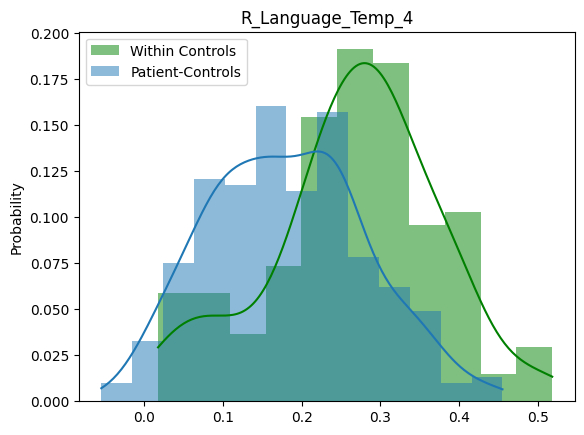

In [7]:
unit = interesting_rois[0]
ISC_mat = pw_ISC[atlas][unit]
_isc_controls = ISC_mat[controls,:][:,controls]
_isc_controls_vec = vectorize_lt_matrix(_isc_controls)
_isc_cross = ISC_mat[patients,:][:,controls]
_isc_cross_vec = _isc_cross.reshape((-1,1))

axes = plt.subplot()
sns.histplot(_isc_controls_vec, stat='probability', kde=True, alpha=0.5, ec='None', ax=axes, label='Within Controls', color='g')
sns.histplot(_isc_cross_vec, stat='probability', kde=True, alpha=0.5, ec='None', ax=axes, label='Patient-Controls', color='r')
plt.title(atlas_labels['Yan2023_Kong2022_400'][unit])
plt.legend()

R_Language_Temp_4


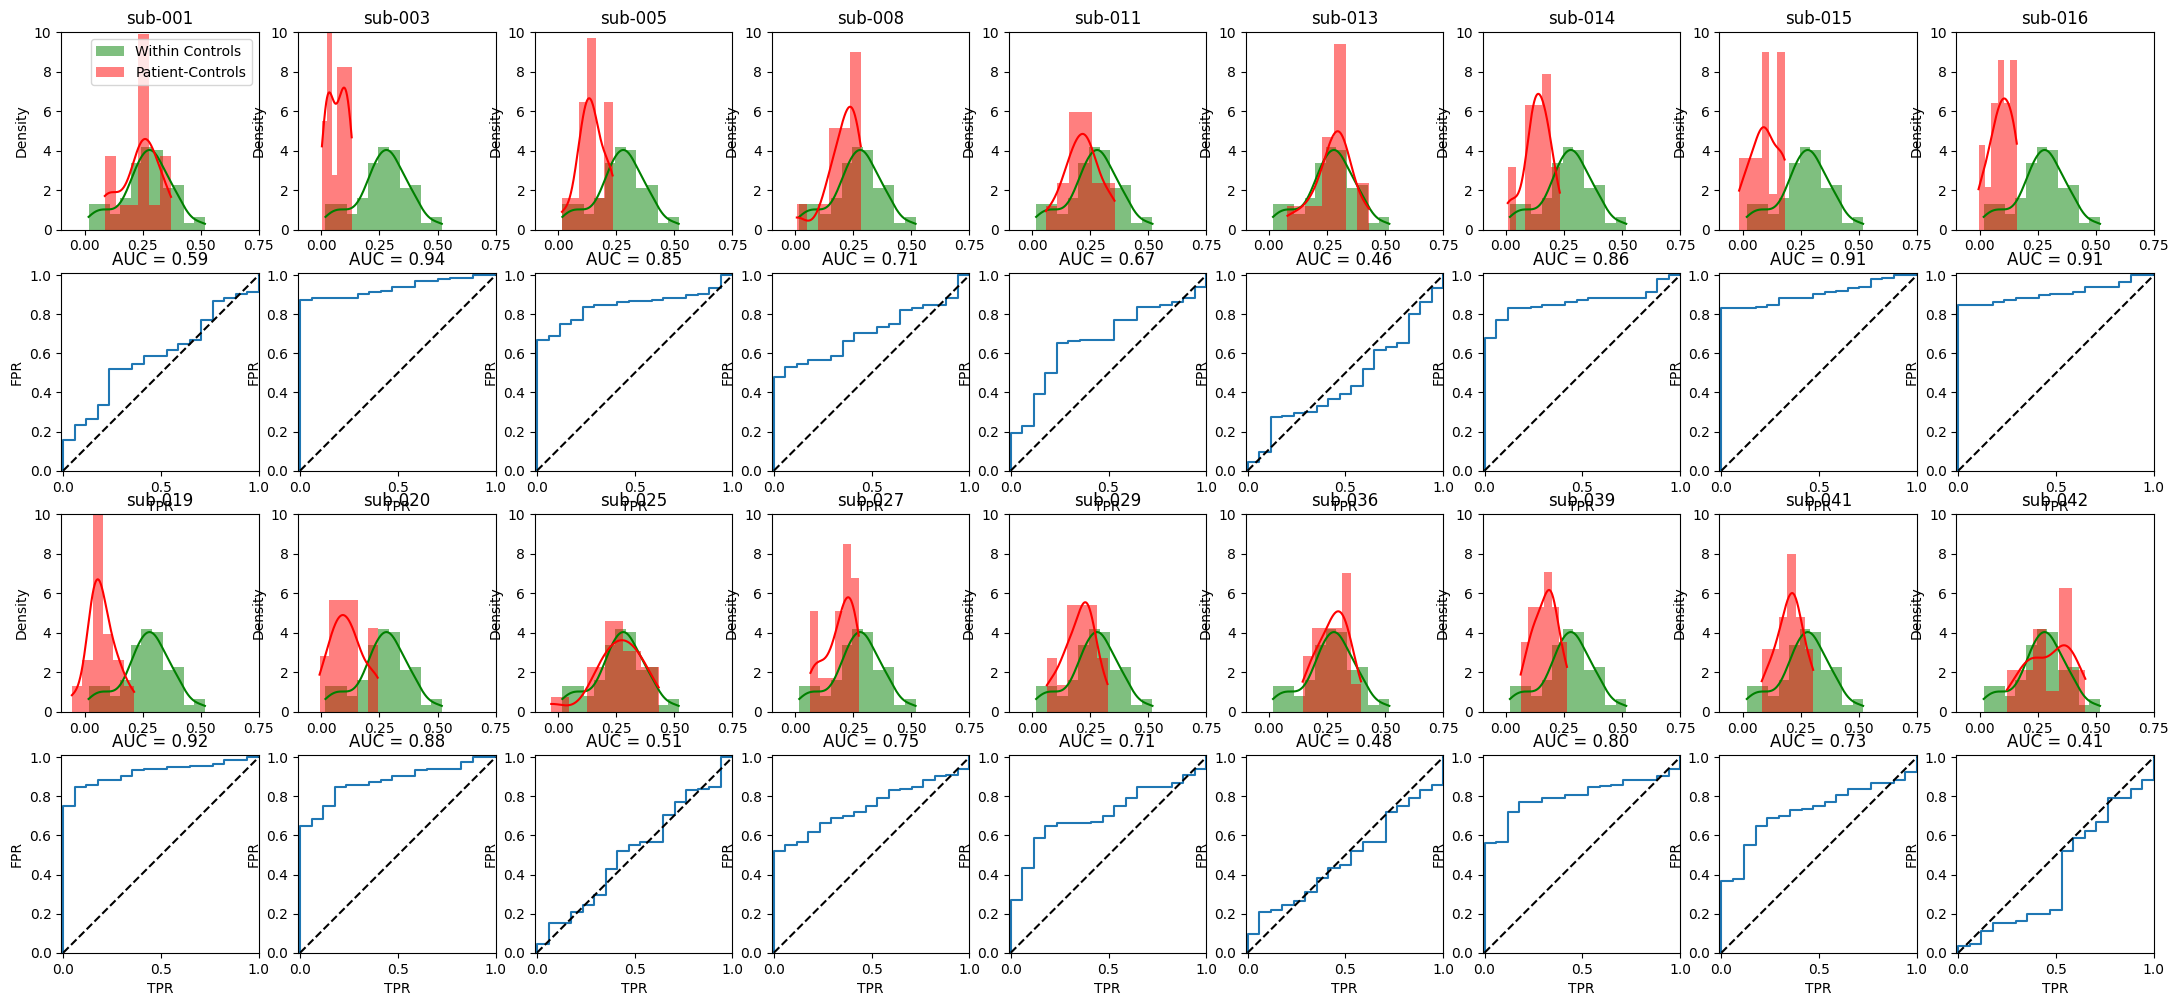

In [8]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve

unit = interesting_rois[0]
print(atlas_labels['Yan2023_Kong2022_400'][unit])
ISC_mat = pw_ISC[atlas][unit]
_isc_controls = ISC_mat[controls,:][:,controls]
_isc_controls_vec = vectorize_lt_matrix(_isc_controls)
_isc_cross = ISC_mat[patients,:][:,controls]

n_patients = patients.sum()
ind_patients = np.where(patients)[0]
fig, axes_t = plt.subplots(4,n_patients//2,figsize=(1.5*n_patients,12))
axes = np.vstack([np.hstack([axes_t[0,:],axes_t[2,:]]),np.hstack([axes_t[1,:],axes_t[3,:]])])

for i in range(n_patients):
    ax = axes[0,i]
    sns.histplot(_isc_controls_vec, stat='density', kde=True, alpha=0.5, ec='None', ax=ax, label='Within Controls', color='g')
    sns.histplot(_isc_cross[i,:], stat='density', kde=True, alpha=0.5, ec='None', ax=ax, label='Patient-Controls', color='r')
    ax.set_title(f'sub-{subjects[ind_patients[i]]:03}')
    ax.set_box_aspect(1)
    ax.set_xlim([-0.1,0.75])
    ax.set_ylim([0,10])
    
    # AUC
    ax = axes[1,i]
    l = np.hstack((-np.ones_like(_isc_controls_vec), np.ones_like(_isc_cross[i,:]))) 
    y = np.hstack((_isc_controls_vec, _isc_cross[i,:]))
    fpr, tpr, _ = roc_curve(l, y, pos_label=1)
    roc_auc = auc(tpr, fpr)

    ax.plot(tpr, fpr)
    ax.plot([0,1],[0,1],'k--')
    ax.set_title(f'AUC = {roc_auc:.2f}')
    ax.set_box_aspect(1)
    ax.set_xlabel('TPR')
    ax.set_ylabel('FPR')
    ax.set_xlim([-0.01,1])
    ax.set_ylim([0,1.01])

axes[0,0].legend()

100%|██████████| 10000/10000 [00:00<00:00, 41082.44it/s]


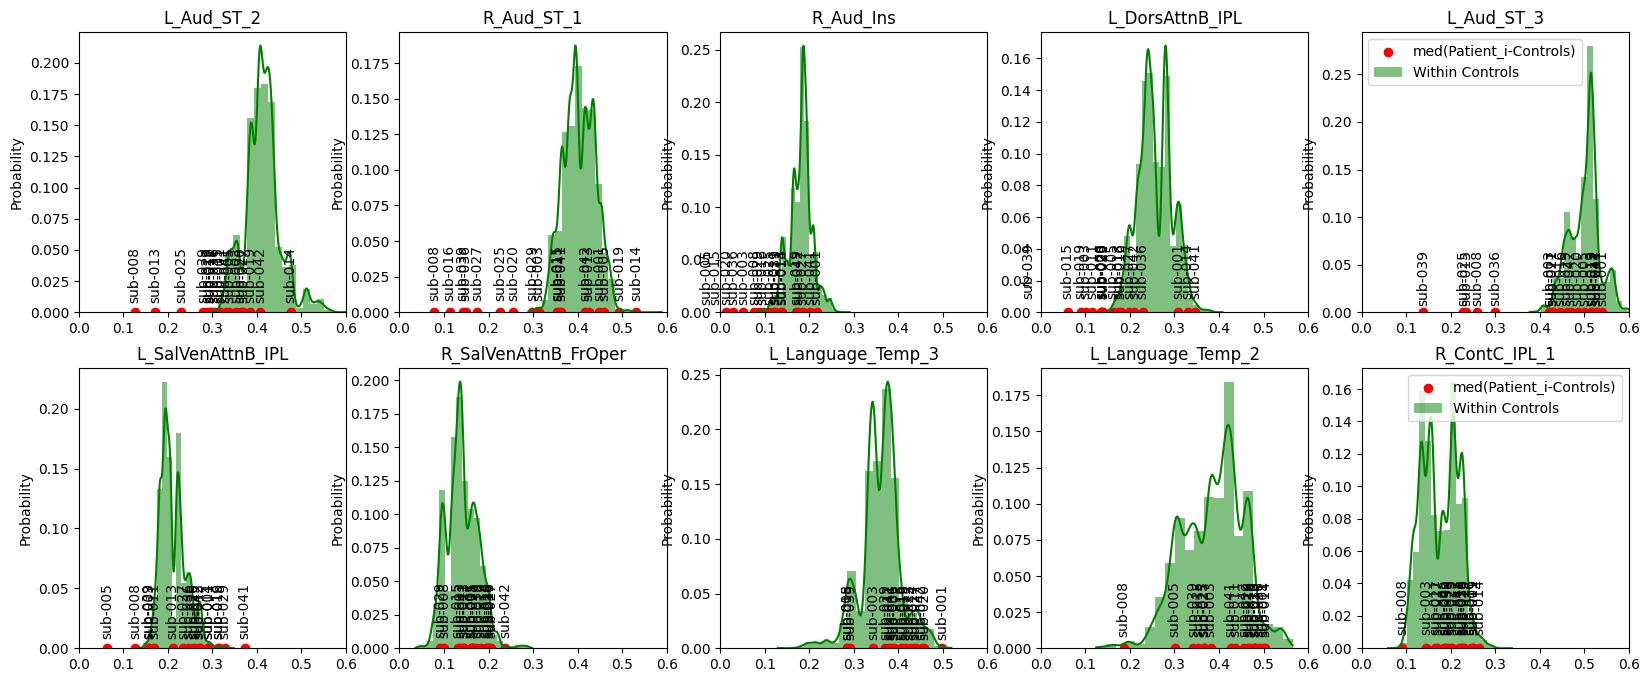

In [10]:
n_perm = 10000
k = 5
fig, axes = plt.subplots(2,k,figsize=(4*k,8))

for u, unit in enumerate(interesting_rois[:k]):
    ax = axes[0,u]
    ISC_mat = pw_ISC[atlas][unit]
    _isc_controls = ISC_mat[controls,:][:,controls]

    stat = np.zeros((n_perm,))
    for p in tqdm(range(n_perm)):
        b = bootstrap_pw_matrix(_isc_controls)
        stat[p] = np.median(b)

    _isc_cross = ISC_mat[patients,:][:,controls]
    _isc_cross_med = np.median(_isc_cross,axis=1)

    tmp = _isc_cross_med.reshape((-1,1))>np.tile(stat, (n_patients,1))
    cdf_dist = tmp.mean(axis=1)

    sns.histplot(stat, ax=ax, label='Within Controls', color='g', stat='probability', bins=20, kde=True, alpha=0.5, ec='None')
    ax.scatter(_isc_cross_med, np.zeros_like(_isc_cross_med), label='med(Patient_i-Controls)', color='r')
    for i in range(n_patients):
        ax.text(x=_isc_cross_med[i], y=0.01, s=f'sub-{subjects[ind_patients[i]]:03}', rotation=90, horizontalalignment='center')
    ax.set_title(atlas_labels['Yan2023_Kong2022_400'][unit])
    ax.set_xlim([0,0.6])
ax.legend()

for u, unit in enumerate(interesting_rois[-k:]):
    ax = axes[1,u]
    ISC_mat = pw_ISC[atlas][unit]
    _isc_controls = ISC_mat[controls,:][:,controls]

    stat = np.zeros((n_perm,))
    for p in tqdm(range(n_perm)):
        b = bootstrap_pw_matrix(_isc_controls)
        stat[p] = np.median(b)

    _isc_cross = ISC_mat[patients,:][:,controls]
    _isc_cross_med = np.median(_isc_cross,axis=1)

    sns.histplot(stat, ax=ax, label='Within Controls', color='g', stat='probability', bins=20, kde=True, alpha=0.5, ec='None')
    ax.scatter(_isc_cross_med, np.zeros_like(_isc_cross_med), label='med(Patient_i-Controls)', color='r')
    for i in range(n_patients):
        ax.text(x=_isc_cross_med[i], y=0.01, s=f'sub-{subjects[ind_patients[i]]:03}', rotation=90, horizontalalignment='center')
    ax.set_title(atlas_labels['Yan2023_Kong2022_400'][unit])
    ax.set_xlim([0,0.6])
ax.legend()

100%|██████████| 10000/10000 [00:00<00:00, 42507.37it/s]


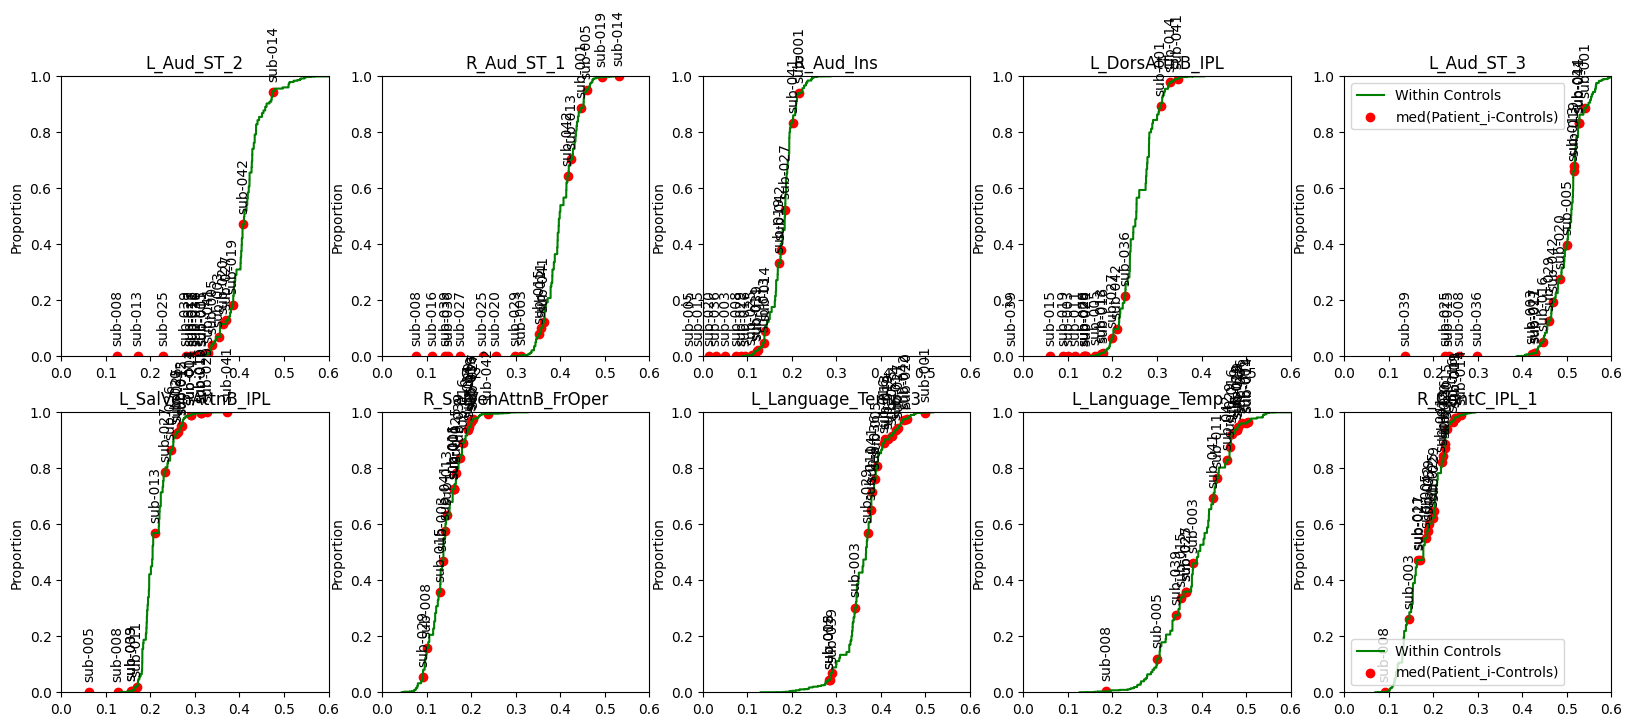

In [11]:
n_perm = 10000
k = 5
fig, axes = plt.subplots(2,k,figsize=(4*k,8))

for u, unit in enumerate(interesting_rois[:k]):
    ax = axes[0,u]
    ISC_mat = pw_ISC[atlas][unit]
    _isc_controls = ISC_mat[controls,:][:,controls]

    stat = np.zeros((n_perm,))
    for p in tqdm(range(n_perm)):
        b = bootstrap_pw_matrix(_isc_controls)
        stat[p] = np.median(b)

    _isc_cross = ISC_mat[patients,:][:,controls]
    _isc_cross_med = np.median(_isc_cross,axis=1)

    tmp = _isc_cross_med.reshape((-1,1))>np.tile(stat, (n_patients,1))
    cdf_dist = tmp.mean(axis=1)

    sns.ecdfplot(stat, ax=ax, label='Within Controls', color='g')
    ax.scatter(_isc_cross_med, cdf_dist, label='med(Patient_i-Controls)', color='r')
    for i in range(n_patients):
        ax.text(x=_isc_cross_med[i], y=cdf_dist[i]+0.05, s=f'sub-{subjects[ind_patients[i]]:03}', rotation=90, horizontalalignment='center')
    ax.set_title(atlas_labels['Yan2023_Kong2022_400'][unit])
    ax.set_xlim([0,0.6])
ax.legend()

for u, unit in enumerate(interesting_rois[-k:]):
    ax = axes[1,u]
    ISC_mat = pw_ISC[atlas][unit]
    _isc_controls = ISC_mat[controls,:][:,controls]

    stat = np.zeros((n_perm,))
    for p in tqdm(range(n_perm)):
        b = bootstrap_pw_matrix(_isc_controls)
        stat[p] = np.median(b)

    _isc_cross = ISC_mat[patients,:][:,controls]
    _isc_cross_med = np.median(_isc_cross,axis=1)

    tmp = _isc_cross_med.reshape((-1,1))>np.tile(stat, (n_patients,1))
    cdf_dist = tmp.mean(axis=1)

    sns.ecdfplot(stat, ax=ax, label='Within Controls', color='g')
    ax.scatter(_isc_cross_med, cdf_dist, label='med(Patient_i-Controls)', color='r')
    for i in range(n_patients):
        ax.text(x=_isc_cross_med[i], y=cdf_dist[i]+0.05, s=f'sub-{subjects[ind_patients[i]]:03}', rotation=90, horizontalalignment='center')
    ax.set_title(atlas_labels['Yan2023_Kong2022_400'][unit])
    ax.set_xlim([0,0.6])
ax.legend()

In [11]:
n_perm = 10000
n_units = pw_ISC[atlas].shape[0]

ab_index = np.zeros((n_units,n_patients))
for unit in tqdm(range(n_units)):
    ISC_mat = pw_ISC[atlas][unit]
    _isc_controls = ISC_mat[controls,:][:,controls]

    stat = np.zeros((n_perm,))
    for p in range(n_perm):
        b = bootstrap_pw_matrix(_isc_controls)
        stat[p] = np.median(b)

    _isc_cross = ISC_mat[patients,:][:,controls]
    _isc_cross_med = np.median(_isc_cross,axis=1)

    tmp = _isc_cross_med.reshape((-1,1))>np.tile(stat, (n_patients,1))
    cdf_dist = tmp.mean(axis=1)

    ab_index[unit,:] = 1-cdf_dist

100%|██████████| 402/402 [01:32<00:00,  4.36it/s]


In [9]:
n_perm = 10000

roc_auc = dict()
for atlas in atlases[1:]:
    print(atlas)
    n_units = pw_ISC[atlas].shape[0]
    _roc_auc = np.zeros((n_units,n_patients))
    for unit in tqdm(range(n_units)):
        ISC_mat = pw_ISC[atlas][unit]
        _isc_controls = ISC_mat[controls,:][:,controls]
        _isc_controls_vec = vectorize_lt_matrix(_isc_controls)
        _isc_cross = ISC_mat[patients,:][:,controls]

        # stat = np.zeros((n_perm,))
        # for p in range(n_perm):
        #     b = bootstrap_pw_matrix(_isc_controls)
        #     stat[p] = np.median(b)

        # _isc_cross_med = np.median(_isc_cross,axis=1)

        # tmp = _isc_cross_med.reshape((-1,1))>np.tile(stat, (n_patients,1))
        # cdf_dist = tmp.mean(axis=1)
        for i in range(n_patients):
            l = np.hstack((-np.ones_like(_isc_controls_vec), np.ones_like(_isc_cross[i,:]))) 
            y = np.hstack((_isc_controls_vec, _isc_cross[i,:]))
            fpr, tpr, _ = roc_curve(l, y, pos_label=1)
            # precision, recall, thresholds = precision_recall_curve(l,y)
            _roc_auc[unit,i] = auc(tpr, fpr)
    roc_auc[atlas] = _roc_auc

Desikan


100%|██████████| 72/72 [00:00<00:00, 204.87it/s]


Glasser2016


100%|██████████| 362/362 [00:01<00:00, 209.73it/s]


Schaefer2018_Kong2022_400


100%|██████████| 402/402 [00:01<00:00, 210.21it/s]


Yan2023_Kong2022_400


100%|██████████| 402/402 [00:01<00:00, 205.38it/s]


In [152]:
output_path = os.path.join('..','surface_maps',dataset,'abnormality_index')

for i, pat_id in enumerate(subjects[ind_patients]):
    data = ab_index[:,i]
    data[~sig[atlas]] = np.nan
    if atlas == 'none':
        n_units = data.shape[0]
        data = {'L': data[:n_units//2], 'R': data[n_units//2:]}
        vertex2gii(data, output_path, f'AI_sub-{pat_id:03}_desc-median_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')
    else:
        atlasfile = os.path.join(atlases_path,f'{atlas}.32k.{{hemi}}.label.gii')
        roi2gii(data, atlasfile, output_path, f'AI_sub-{pat_id:03}_desc-median_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')


In [55]:
output_path = os.path.join('..','surface_maps',dataset,'roc_auc')
filename_pattern = f'sub-{{pat_id:03}}_desc-auc_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{{atlas}}'

for atlas in atlases[1:]:
    for i, pat_id in enumerate(subjects[ind_patients]):
        data = roc_auc[atlas][:,i]
        data[~sig[atlas]] = np.nan
        if atlas == 'none':
            n_units = data.shape[0]
            data = {'L': data[:n_units//2], 'R': data[n_units//2:]}
            vertex2gii(data, output_path, filename_pattern.format(pat_id=pat_id, atlas=atlas))
        else:
            atlasfile = os.path.join(atlases_path,f'{atlas}.32k.{{hemi}}.label.gii')
            roi2gii(data, atlasfile, output_path, filename_pattern.format(pat_id=pat_id, atlas=atlas))

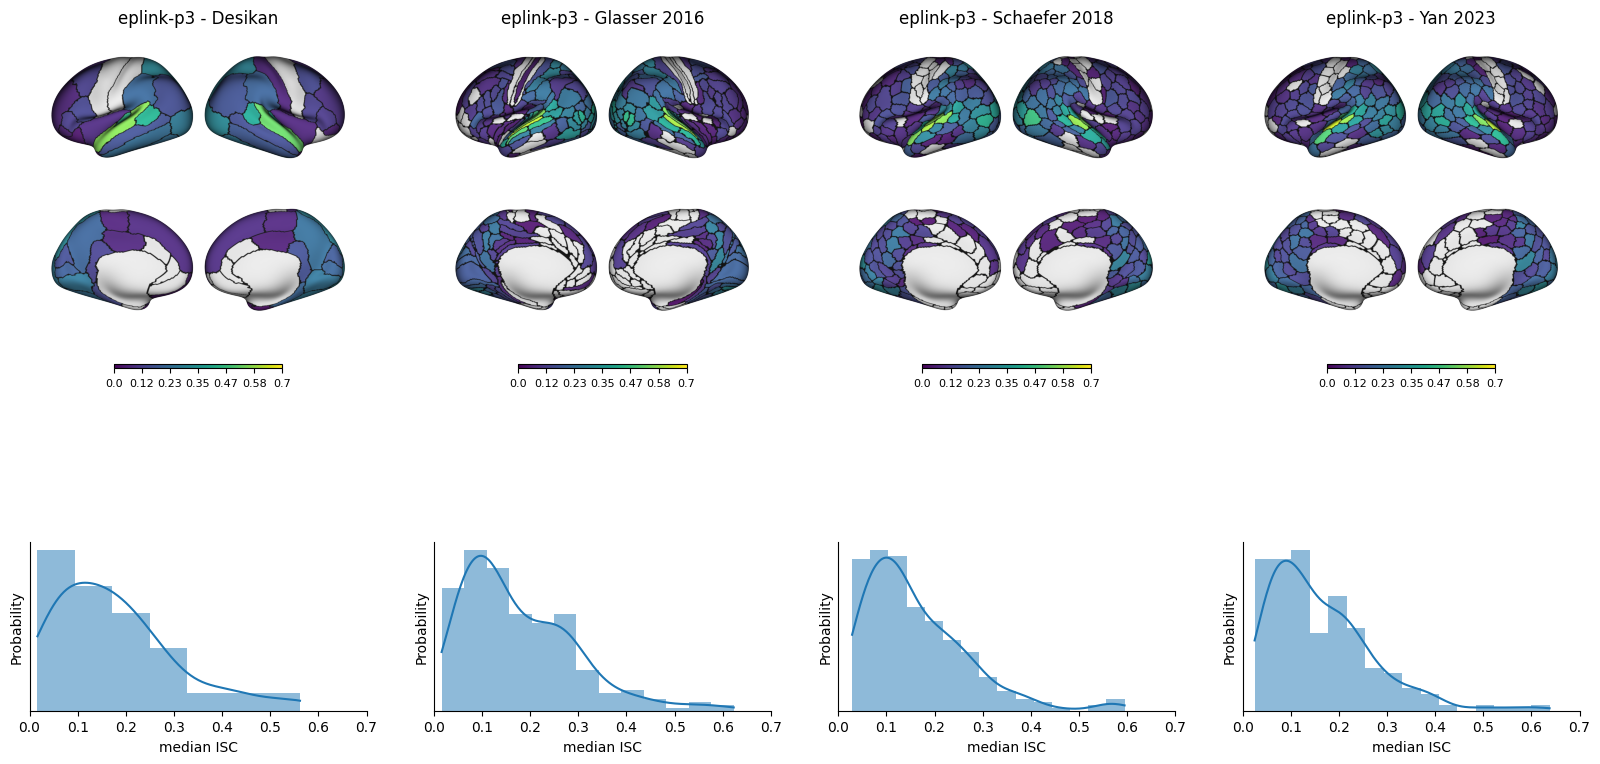

In [14]:
clim = [0, 0.7]
mesh = 'very_inflated'
surf_mesh = os.path.join(local_root, 'ISC-pipeline', 'resources', 'fsLR_32K_surfaces', f'fs_LR.32k.{{hemi}}.{mesh}.surf.gii')


importlib.reload(utils.Vis)
from utils.Vis import plot_maps
fig, axes = plt.subplots(2,4,figsize=(20,10))
# plot ISC median maps
for i, atlas in enumerate(atlases[1:]):
    if atlas != 'none':
        atlasfile = os.path.join(atlases_path,f'{atlas}.32k.{{hemi}}.label.gii')
    else:
        atlasfile = None
    map_path = os.path.join('..','surface_maps',dataset,f'pwISC_desc-median_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_{{hemi}}.shape.gii')
    plot_maps(map_path, surf_mesh=surf_mesh, atlas=atlasfile, title=f'{dataset} - {atlases_aliases[i+1]}', ax=axes[0,i], range=clim)
# plot ISC median histogram
for i, atlas in enumerate(atlases[1:]):        
    ax = axes[1,i]

    sns.histplot(median_ISC[f'{atlas}'], ec='None', stat='probability', kde=True, ax=ax)

    ax.set_box_aspect(0.5)
    # axes[3,i].set_xlim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # axes[s].spines['bottom'].set_visible(False)Please send me the link to the data and let me know if you have any questions.
    # ax.spines['left'].set_visible(False)
    ax.set_xlabel('median ISC')
    ax.set_yticks([])
    ax.set_xlim(clim)

# # plot ISC cv maps
# for i, atlas in enumerate(atlases[1:]):
#     if atlas != 'none':
#         atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
#     else:
#         atlasfile = None
#     map_path = os.path.join('.','surface_maps','phases_combined',f'looISC_desc-cv_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_{{hemi}}.shape.gii')
#     plot_maps(map_path, atlas=atlasfile, cmap='magma', title=f'combined - {atlases_aliases[i+1]}', clabel='log(cv)', ax=axes[2,i], range=[-2,4])
# # plot ISC cv histogram
# for i, atlas in enumerate(atlases[1:]):
#     # if atlas == 'none': 
#     #     continue
#     ax = axes[3,i]
#     sns.histplot(cv[f'{atlas}'], ec='None', stat='probability', kde=True, ax=ax)
#     ax.set_box_aspect(0.5)
#     # axes[3,i].set_xlim(0,1)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     # axes[s].spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.set_xlabel('log(cv)')
#     ax.set_yticks([])

# TODO: for ROIs with high ISC mean plot histogram

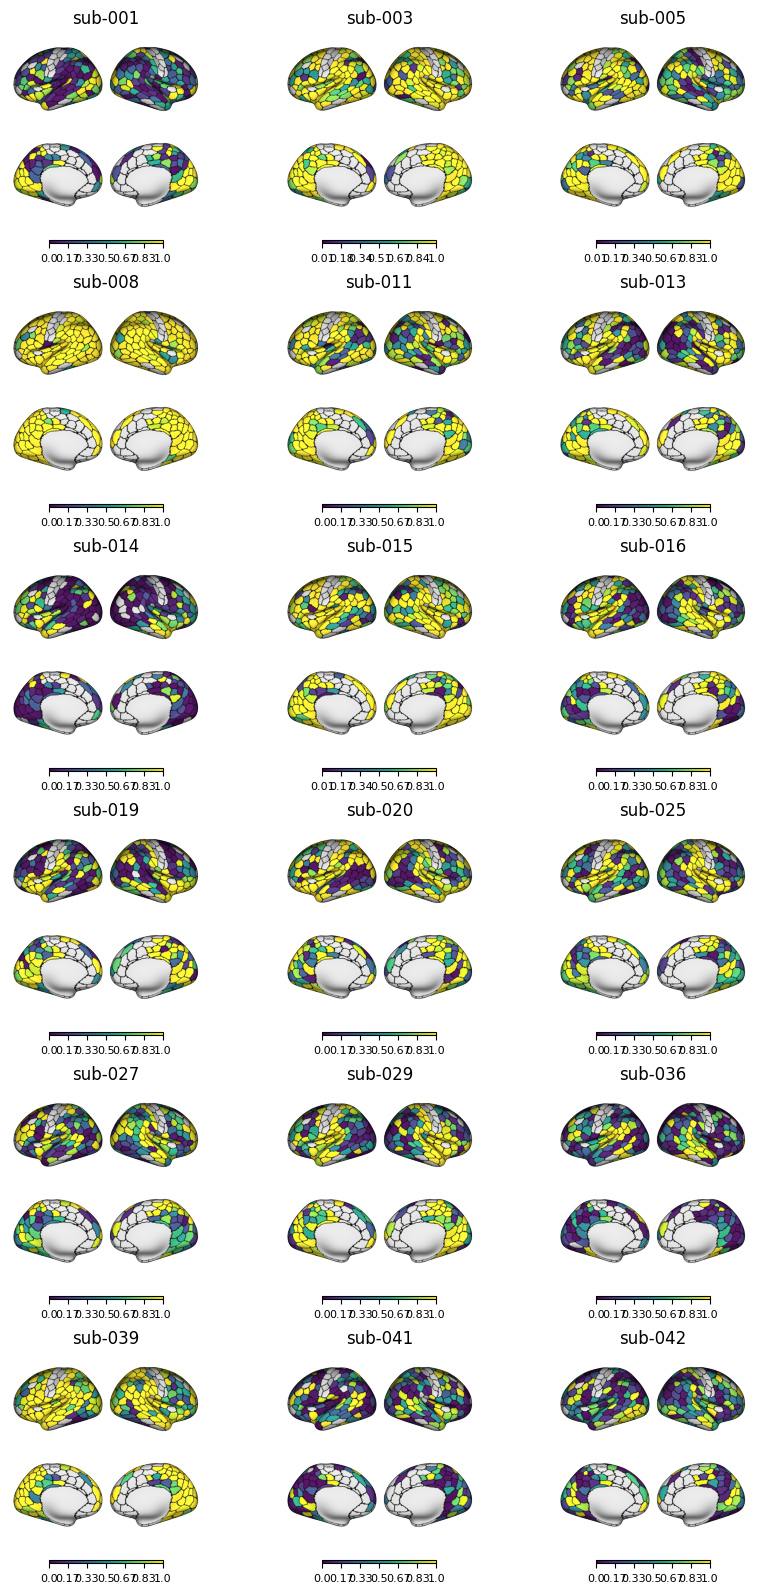

In [153]:
clim = None#[0.1, 0.7]
mesh = 'very_inflated'
surf_mesh = os.path.join(local_root, 'ISC-pipeline', 'resources', 'fsLR_32K_surfaces', f'fs_LR.32k.{{hemi}}.{mesh}.surf.gii')


importlib.reload(utils.Vis)
from utils.Vis import plot_maps
fig, axes = plt.subplots(6,3,figsize=(10,20))
axes = axes.reshape((n_patients,))

# plot patients maps

for i, pat_id in enumerate(subjects[ind_patients]):
    ax = axes[i]
    if atlas != 'none':
        atlasfile = os.path.join(atlases_path,f'{atlas}.32k.{{hemi}}.label.gii')
    else:
        atlasfile = None
    map_path = os.path.join('..','surface_maps',dataset,'abnormality_index',f'AI_sub-{pat_id:03}_desc-median_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_{{hemi}}.shape.gii')
    plot_maps(map_path, surf_mesh=surf_mesh, atlas=atlasfile, title=f'sub-{pat_id:03}', ax=ax, range=clim)

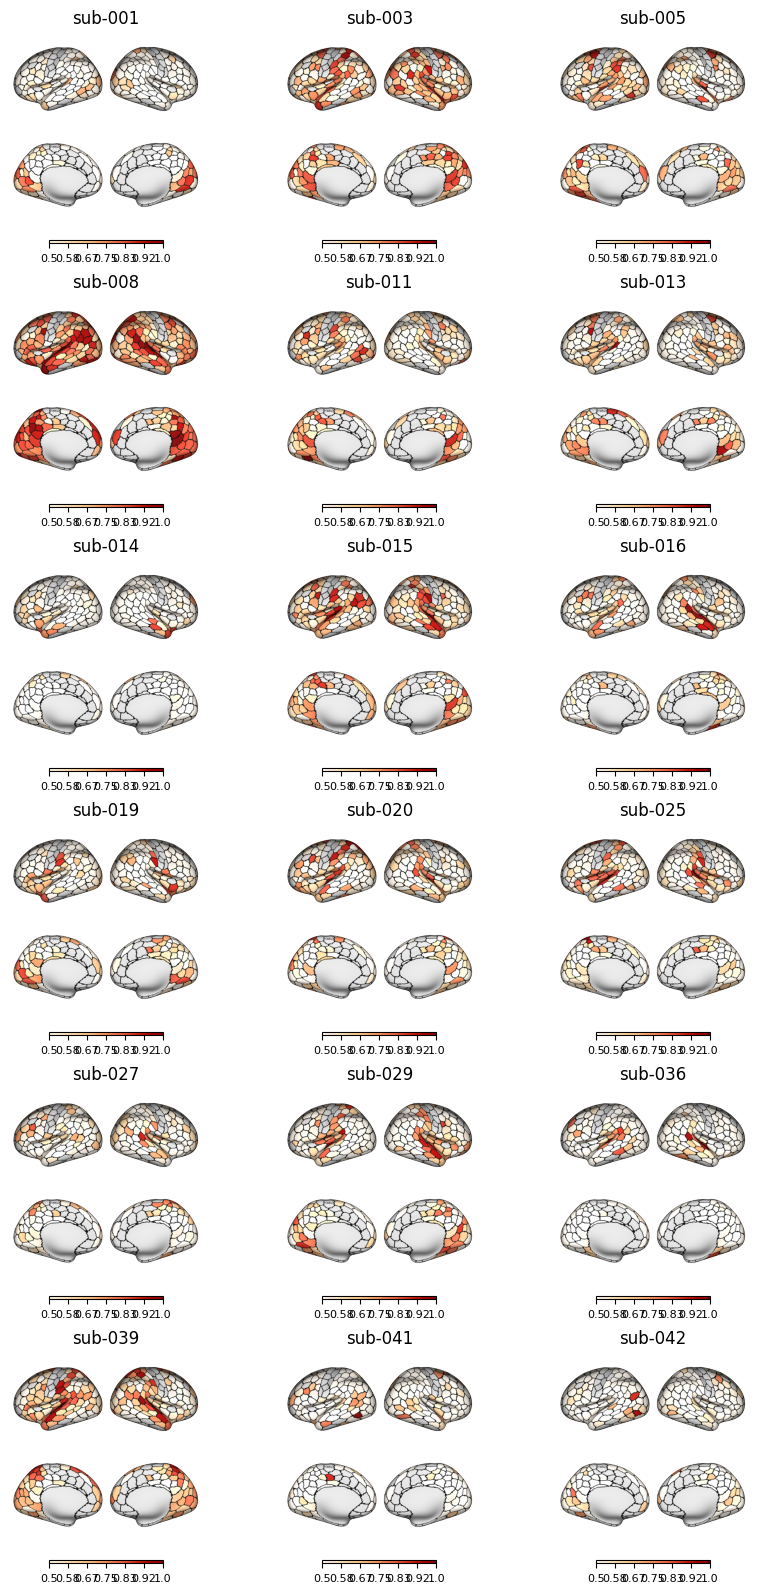

In [12]:
clim = [0.5, 1]
mesh = 'very_inflated'
surf_mesh = os.path.join(local_root, 'ISC-pipeline', 'resources', 'fsLR_32K_surfaces', f'fs_LR.32k.{{hemi}}.{mesh}.surf.gii')
filename_pattern = f'sub-{{pat_id:03}}_desc-auc_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{{atlas}}_{{hemi}}.shape.gii'

importlib.reload(utils.Vis)
from utils.Vis import plot_maps
fig, axes = plt.subplots(6,3,figsize=(10,20))
axes = axes.reshape((n_patients,))

# plot patients maps

for i, pat_id in enumerate(subjects[ind_patients]):
    ax = axes[i]
    if atlas != 'none':
        atlasfile = os.path.join(atlases_path,f'{atlas}.32k.{{hemi}}.label.gii')
    else:
        atlasfile = None
    map_path = os.path.join('..','surface_maps',dataset,'roc_auc',filename_pattern.format(pat_id=pat_id, atlas=atlas, hemi='{hemi}'))
    plot_maps(map_path, surf_mesh=surf_mesh, atlas=atlasfile, title=f'sub-{pat_id:03}', ax=ax, range=clim, cmap='OrRd')

In [15]:
roc_auc[atlas][:,i].shape

(402,)

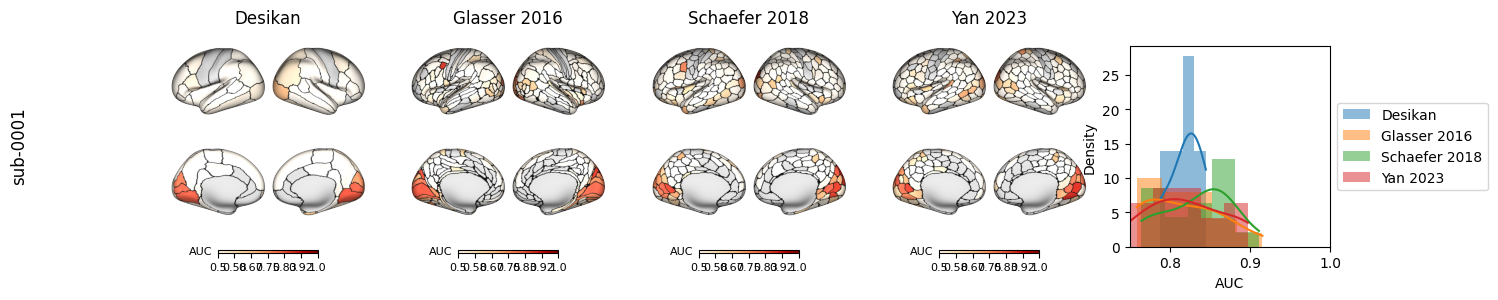

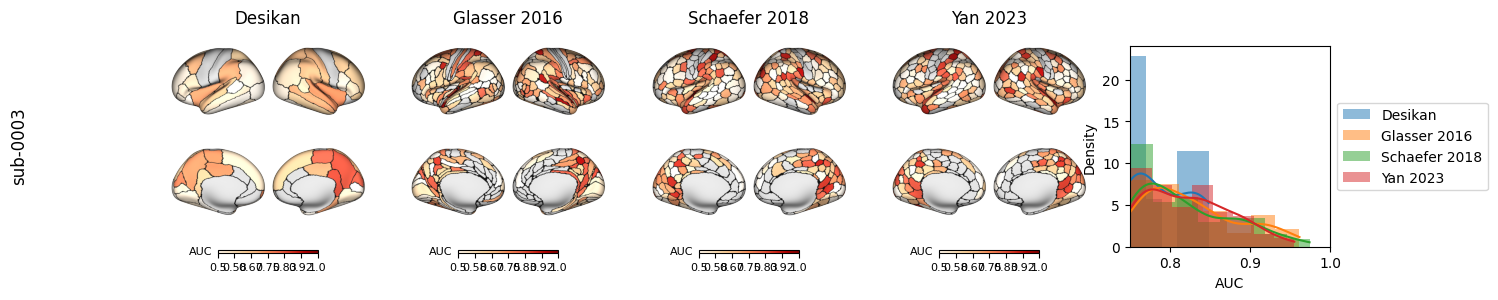

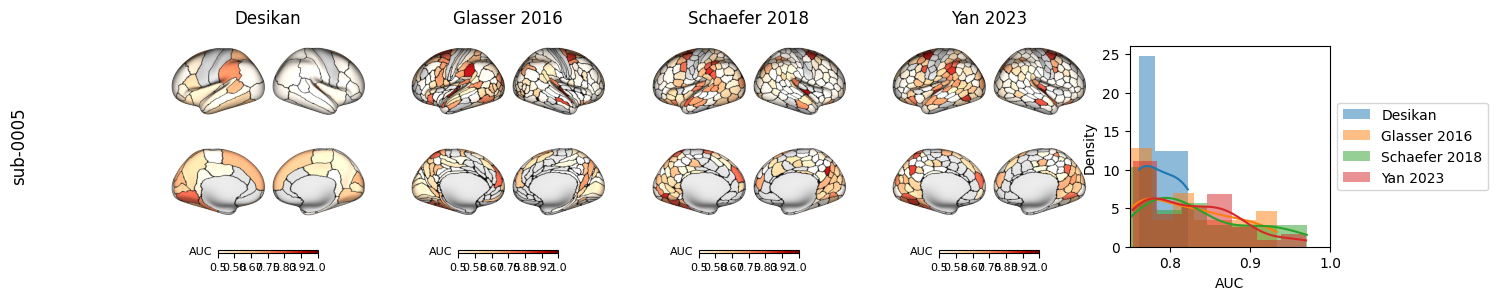

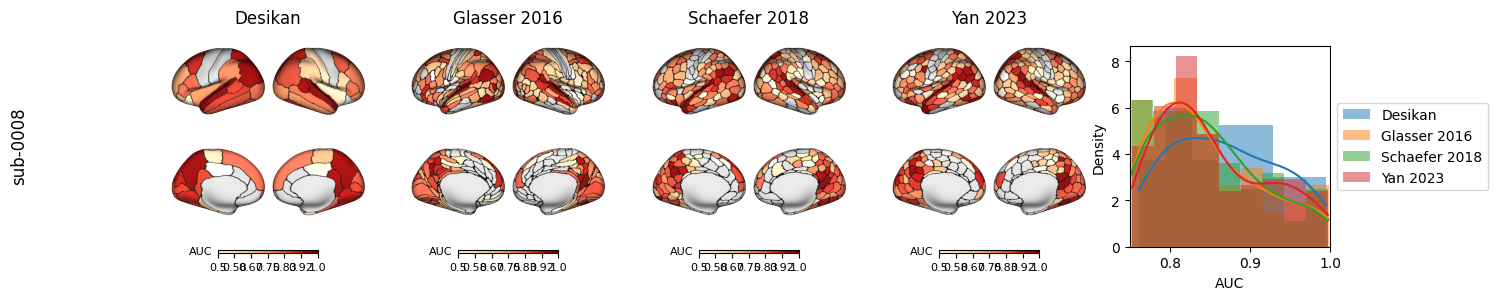

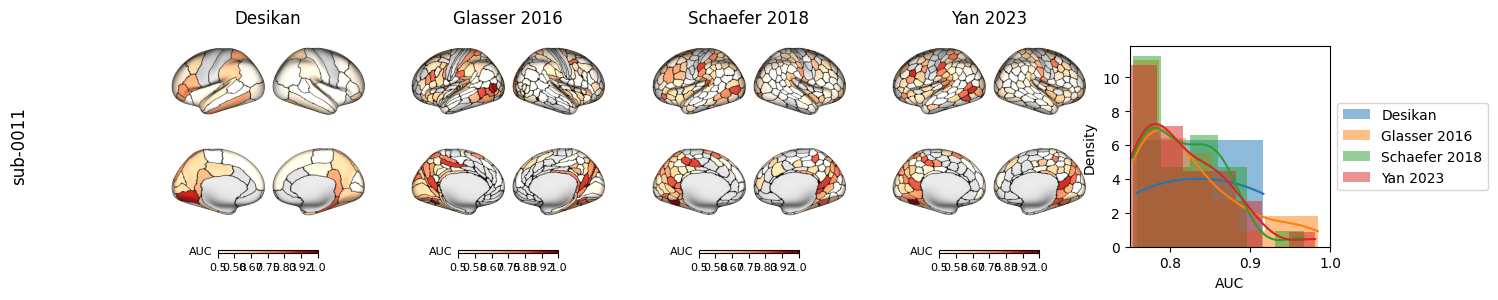

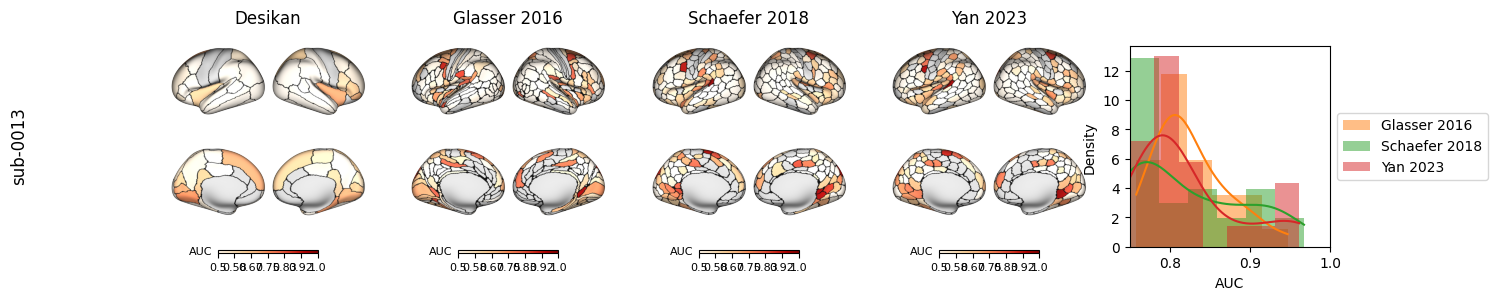

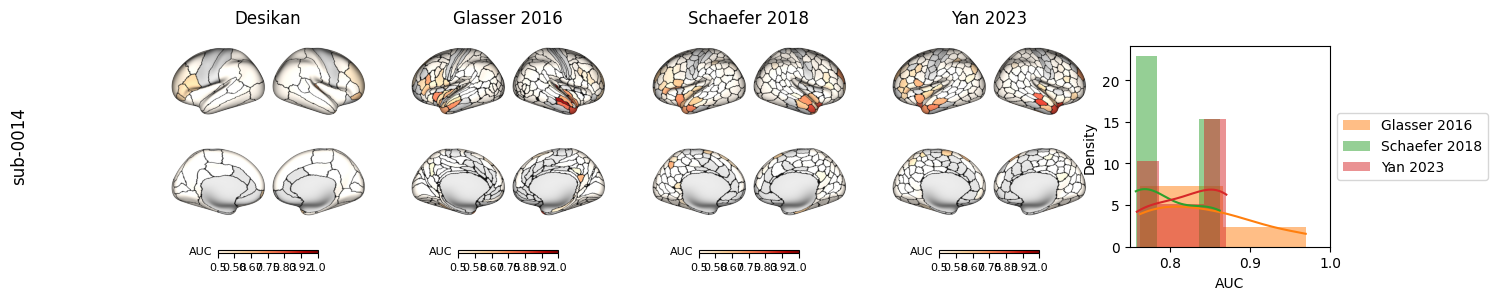

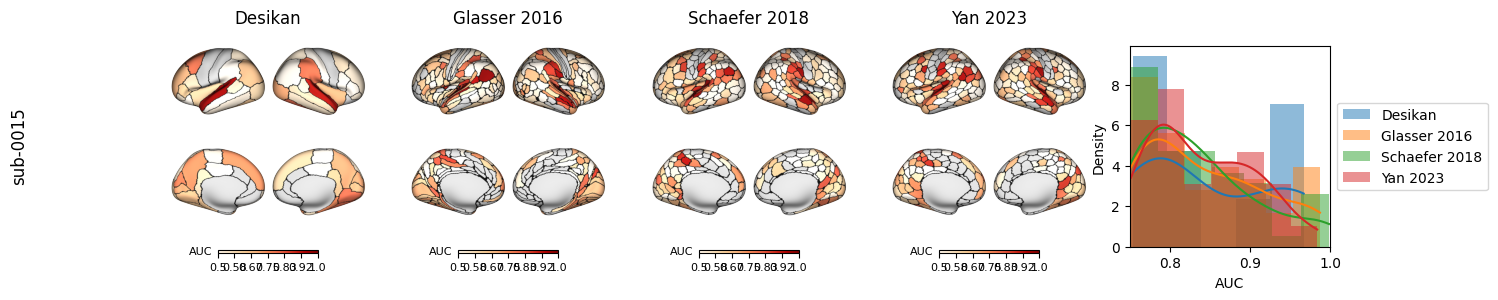

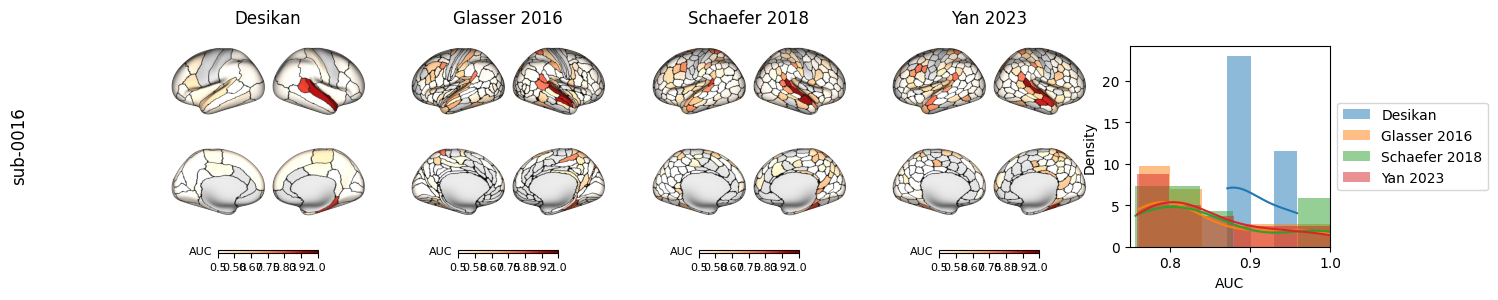

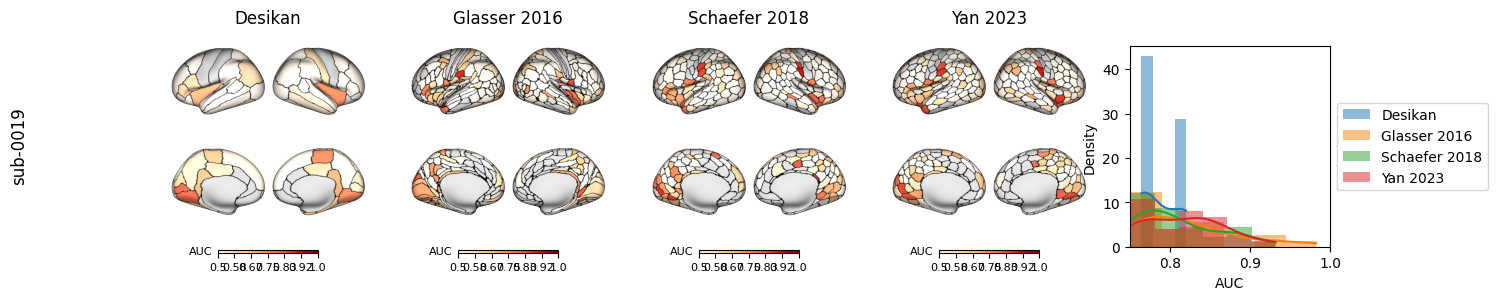

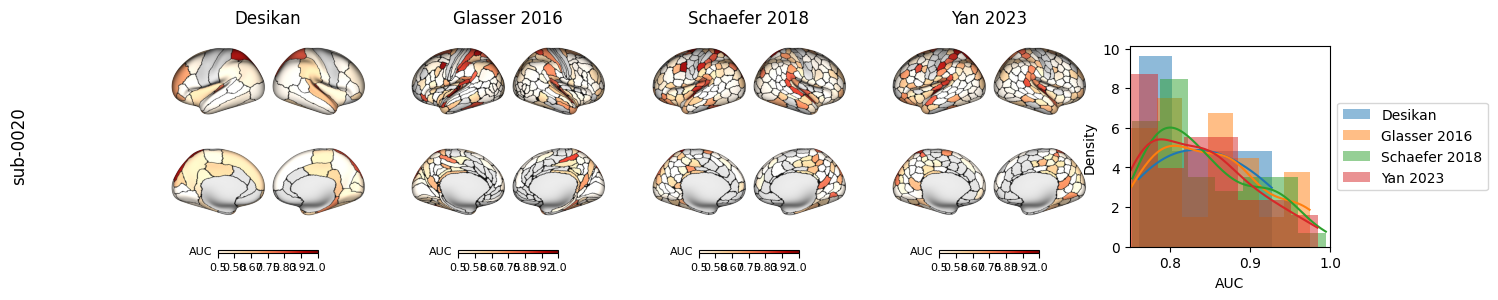

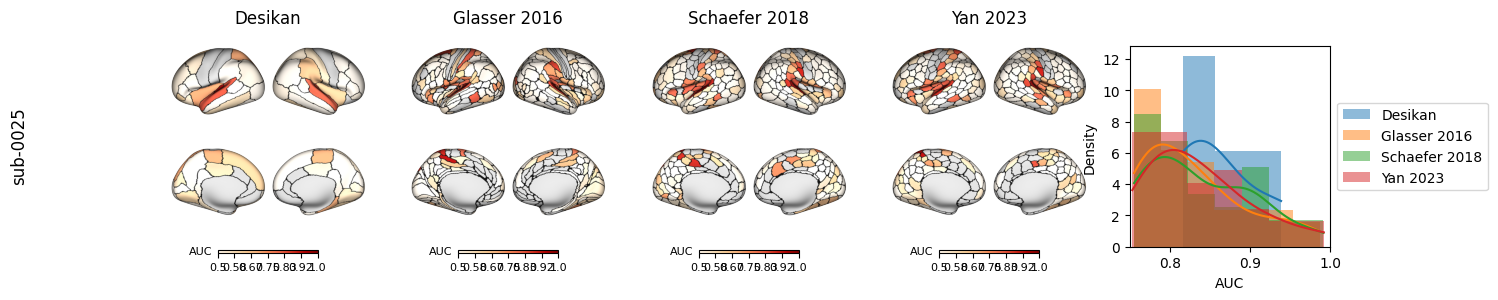

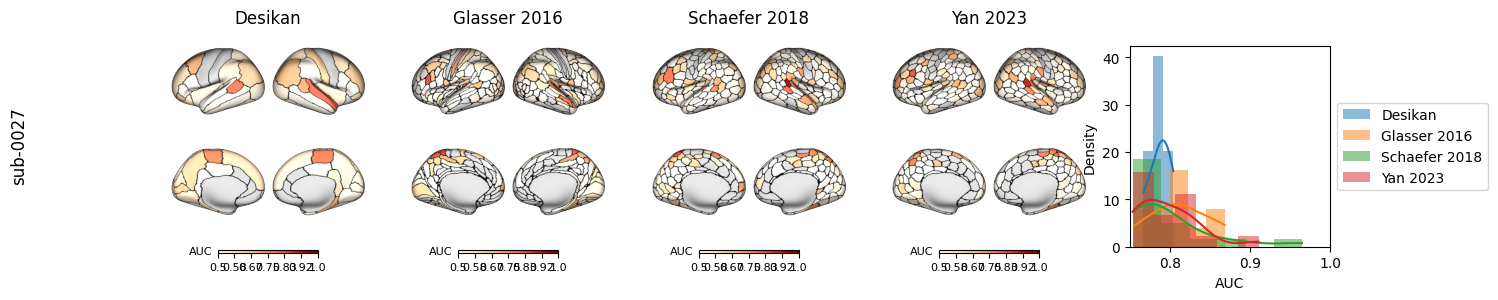

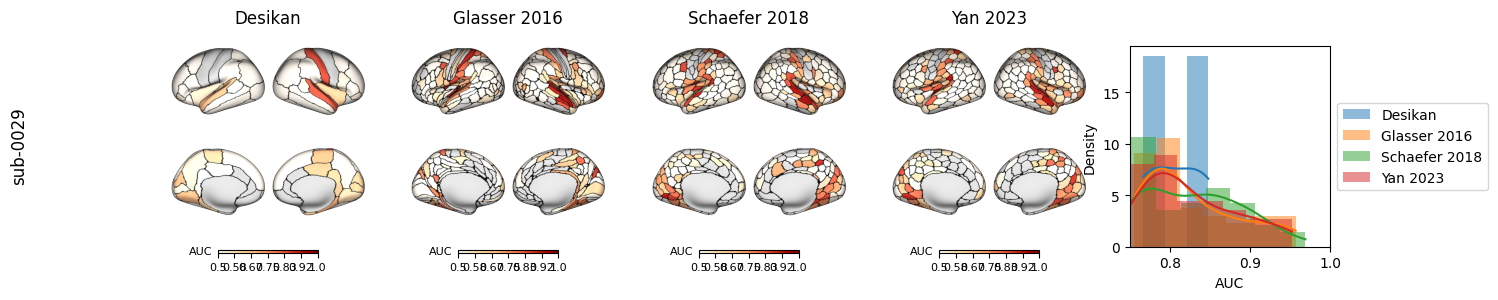

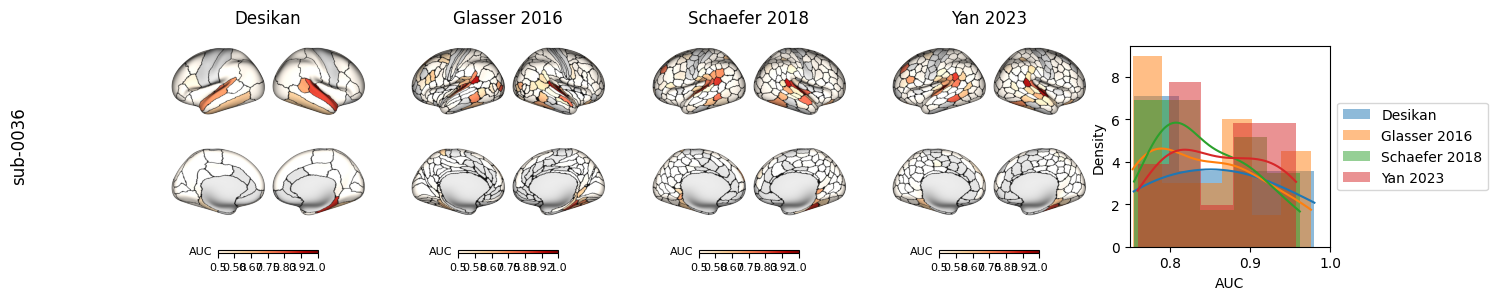

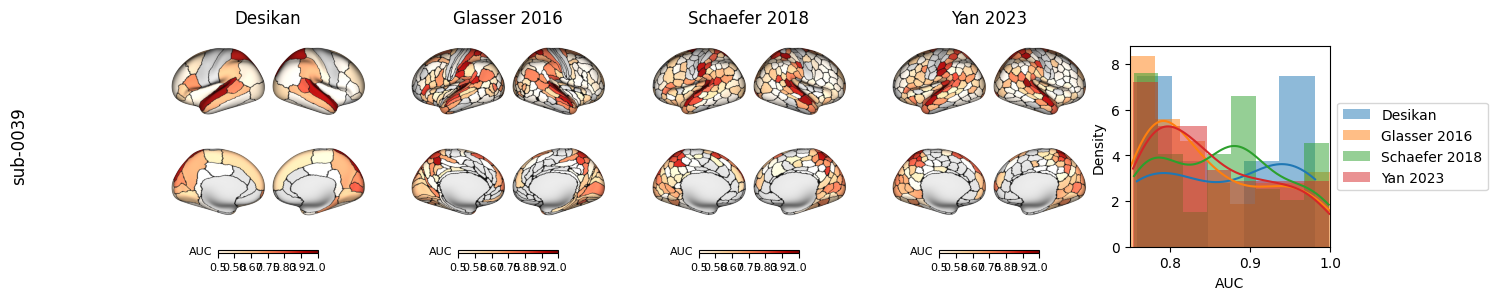

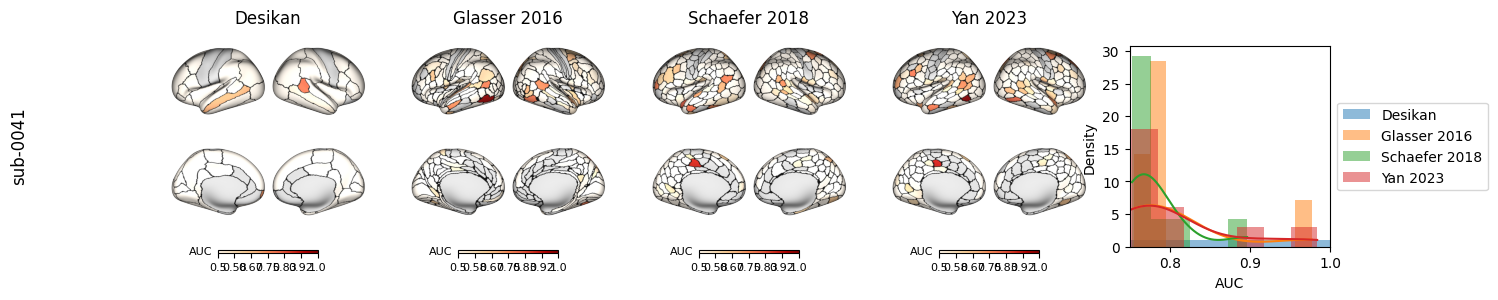

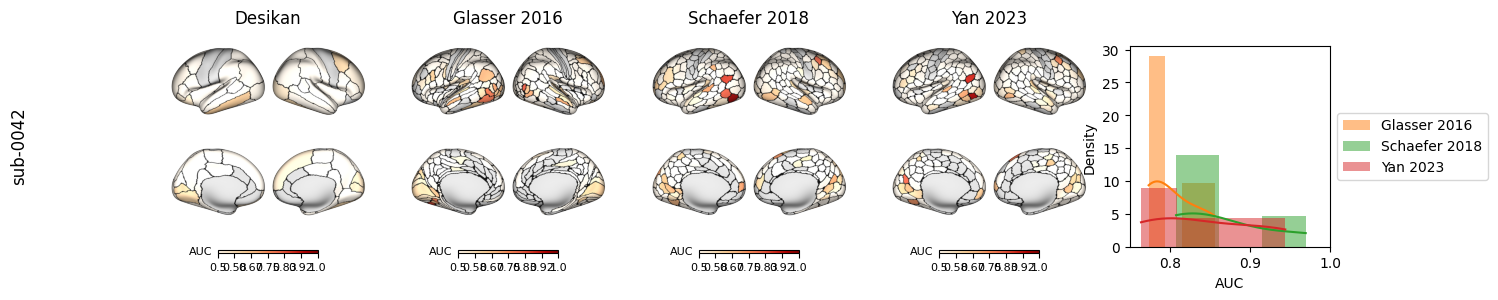

In [11]:
clim = [0.5, 1]
mesh = 'very_inflated'
surf_mesh = os.path.join(local_root, 'ISC-pipeline', 'resources', 'fsLR_32K_surfaces', f'fs_LR.32k.{{hemi}}.{mesh}.surf.gii')
filename_pattern = f'sub-{{pat_id:03}}_desc-auc_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{{atlas}}_{{hemi}}.shape.gii'

importlib.reload(utils.Vis)
from utils.Vis import plot_maps

# axes = axes.reshape((len(atlases)-1,))

# plot patients maps

i = 2
pat_id = subjects[ind_patients[i]]

for i, pat_id in enumerate(subjects[ind_patients]):
    fig, axes = plt.subplots(1,len(atlases),figsize=(15,3))
    for j, atlas in enumerate(atlases[1:]):
        ax = axes[j]
        if atlas != 'none':
            atlasfile = os.path.join(atlases_path,f'{atlas}.32k.{{hemi}}.label.gii')
        else:
            atlasfile = None
        map_path = os.path.join('..','surface_maps',dataset,'roc_auc',filename_pattern.format(pat_id=pat_id, atlas=atlas, hemi='{hemi}'))
        plot_maps(map_path, surf_mesh=surf_mesh, atlas=atlasfile, title=atlases_aliases[j+1], ax=ax, range=clim, cmap='OrRd', clabel='AUC')

        ax = axes[-1]
        temp = roc_auc[atlas][:,i]
        temp2 = temp[temp>0.75]
        sns.histplot(temp2, label=atlases_aliases[j+1], alpha=0.5, stat='density', kde=True, ax=ax, ec=None)

    axes[-1].legend(bbox_to_anchor=(1, 0.5),loc='center left')
    axes[-1].set_box_aspect(1)
    axes[-1].set_xlabel('AUC')
    axes[-1].set_xlim([0.75, 1])

    fig.supylabel(f'sub-{pat_id:04}')
    plt.savefig(f'./fig/auc_sub-{pat_id:04}')

In [12]:
# TODO: Coverage of abnormal areas (threshold the AUC to define abnormal areas)

i = 0
roc_auc[atlas][:,i]

array([0.35510381, 0.53157439, 0.4982699 , 0.32915225, 0.59126298,
       0.68252595, 0.43598616, 0.20847751, 0.35769896, 0.28892734,
       0.56401384, 0.49178201, 0.33391003, 0.27076125, 0.46929066,
       0.40484429, 0.42733564, 0.31271626, 0.5916955 , 0.58650519,
       0.65138408, 0.39619377, 0.35726644, 0.24913495, 0.52508651,
       0.35683391, 0.41868512, 0.39619377, 0.31401384, 0.37283737,
       0.39316609, 0.27595156, 0.22491349, 0.52984429, 0.34385813,
       0.41306228, 0.56704152, 0.52897924, 0.57050173, 0.49307958,
       0.35034602, 0.48788927, 0.308391  , 0.24697232, 0.31487889,
       0.30233564, 0.49394464, 0.62197232, 0.62846021, 0.53157439,
       0.5       , 0.31574394, 0.32396194, 0.52724913, 0.63581315,
       0.48399654, 0.32309689, 0.39749135, 0.30233564, 0.3884083 ,
       0.5683391 , 0.35769896, 0.44679931, 0.41435986, 0.58304498,
       0.54195502, 0.53633218, 0.52249135, 0.39186851, 0.3183391 ,
       0.68252595, 0.35207612, 0.47794118, 0.46885813, 0.36894